In [2]:
import requests
import pandas as pd

cities = {
    'Ahmedabad': (23.07, 72.63),
    'Delhi': (28.61, 77.21),
    'Mumbai': (19.08, 72.87),
    'Bangalore': (12.97, 77.59)
}

def fetch_data(lat, lon, start='2024-01-01', end='2024-12-31'):  # Smaller range
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={start}&end_date={end}&hourly=temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,precipitation"
    try:
        resp = requests.get(url).json()
        print(f"Response for {lat},{lon}: {resp}")  # Debug
        if 'hourly' not in resp:
            print(f"Error: No 'hourly' key for lat={lat}, lon={lon}. Response: {resp}")
            return pd.DataFrame()
        df = pd.DataFrame(resp['hourly'])
        df['time'] = pd.to_datetime(df['time'])
        return df
    except Exception as e:
        print(f"Request failed for lat={lat}, lon={lon}: {e}")
        return pd.DataFrame()

# Fetch and combine
dfs = []
for city, (lat, lon) in cities.items():
    df = fetch_data(lat, lon)
    if not df.empty:
        df['city'] = city
        dfs.append(df)
    else:
        print(f"No data for {city}")

if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    df_all.to_csv('multi_city_hist.csv', index=False)
    print(df_all.groupby('city').size())
else:
    print("No data fetched. Using mock data.")
    # Mock data fallback
    import numpy as np
    dates = pd.date_range('2024-01-01', '2024-12-31', freq='H')
    mock_data = {
        'time': dates,
        'temperature_2m': np.random.uniform(20, 35, len(dates)),
        'relative_humidity_2m': np.random.uniform(50, 90, len(dates)),
        'pressure_msl': np.random.uniform(990, 1010, len(dates)),
        'wind_speed_10m': np.random.uniform(0, 40, len(dates)),
        'precipitation': np.random.uniform(0, 10, len(dates)),
        'city': 'Ahmedabad'
    }
    df_all = pd.DataFrame(mock_data)
    df_all.to_csv('multi_city_hist.csv', index=False)
    print("Mock data saved for Ahmedabad.")

Response for 23.07,72.63: {'latitude': 23.093145, 'longitude': 72.58368, 'generationtime_ms': 1.2444257736206055, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 56.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'relative_humidity_2m': '%', 'pressure_msl': 'hPa', 'wind_speed_10m': 'km/h', 'precipitation': 'mm'}, 'hourly': {'time': ['2024-01-01T00:00', '2024-01-01T01:00', '2024-01-01T02:00', '2024-01-01T03:00', '2024-01-01T04:00', '2024-01-01T05:00', '2024-01-01T06:00', '2024-01-01T07:00', '2024-01-01T08:00', '2024-01-01T09:00', '2024-01-01T10:00', '2024-01-01T11:00', '2024-01-01T12:00', '2024-01-01T13:00', '2024-01-01T14:00', '2024-01-01T15:00', '2024-01-01T16:00', '2024-01-01T17:00', '2024-01-01T18:00', '2024-01-01T19:00', '2024-01-01T20:00', '2024-01-01T21:00', '2024-01-01T22:00', '2024-01-01T23:00', '2024-01-02T00:00', '2024-01-02T01:00', '2024-01-02T02:00', '2024-01-02T03:00', '2024-01-02T04:00', '2024-01-02T05:00', '2024-01-

In [3]:
df = pd.read_csv('multi_city_hist.csv', parse_dates=['time'])
df['event'] = 'normal'
df.loc[(df['precipitation'] > 5) & (df['relative_humidity_2m'] > 80), 'event'] = 'thunderstorm'
df.loc[df['wind_speed_10m'] > 30, 'event'] = 'wind'
df['event_code'] = df['event'].map({'normal': 0, 'wind': 1, 'thunderstorm': 2})
df['wind_next'] = df.groupby('city')['wind_speed_10m'].shift(-1).fillna(df['wind_speed_10m'].mean())
df.to_csv('multi_city_labeled.csv', index=False)
print(df.groupby(['city', 'event']).size())

city       event       
Ahmedabad  normal          8723
           thunderstorm      45
           wind              16
Bangalore  normal          8718
           thunderstorm      20
           wind              46
Delhi      normal          8720
           thunderstorm      51
           wind              13
Mumbai     normal          8677
           thunderstorm      76
           wind              31
dtype: int64


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'precipitation']
seq_len = 120

def create_sequences(data, seq_len):
    X, y_class, y_reg = [], [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y_class.append(data[i, -1])  # event_code
        y_reg.append(data[i, 3])  # wind_speed_next
    return np.array(X), np.array(y_class), np.array(y_reg)

# Load labeled data
df = pd.read_csv('multi_city_labeled.csv', parse_dates=['time'])
cities = df['city'].unique()

# Scale per city
X_all, y_class_all, y_reg_all = [], [], []
for city in cities:
    df_city = df[df['city'] == city]
    data = df_city[features].ffill().values  # Updated: fillna(method='ffill') -> ffill()
    scaler = StandardScaler().fit(data)
    data_scaled = scaler.transform(data)
    data_scaled = np.column_stack((df_city['event_code'].values.reshape(-1,1), data_scaled))
    X, y_class, y_reg = create_sequences(data_scaled, seq_len)
    X_all.append(X)
    y_class_all.append(y_class)
    y_reg_all.append(y_reg)

X = np.concatenate(X_all)
y_class = np.concatenate(y_class_all)
y_reg = np.concatenate(y_reg_all)

X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(X, y_class, y_reg, test_size=0.2)
print(f"X shape: {X_train.shape}")

X shape: (27724, 120, 6)


In [11]:
import pandas as pd

# Load labeled data
df = pd.read_csv('multi_city_labeled.csv', parse_dates=['time'])

# Check event_code and event values
print("Unique event_code values:", df['event_code'].unique())
print("Event counts:\n", df['event'].value_counts())
print("Sample data:\n", df[['event', 'event_code']].head(10))

# Fix event_code
df['event'] = df['event'].str.lower().str.strip()  # Normalize strings
df['event_code'] = df['event'].map({'normal': 0, 'wind': 1, 'thunderstorm': 2})

# Check for invalid or NaN values
if df['event_code'].isna().any():
    print("Found NaN in event_code. Setting to 0 (normal).")
    df['event_code'] = df['event_code'].fillna(0)

# Verify range
if df['event_code'].max() > 2 or df['event_code'].min() < 0:
    print("Invalid event_code values found. Setting out-of-range to 0.")
    df.loc[~df['event_code'].isin([0, 1, 2]), 'event_code'] = 0

# Save fixed data
df.to_csv('multi_city_labeled_fixed.csv', index=False)
print("Fixed data saved as multi_city_labeled_fixed.csv")
print("New unique event_code values:", df['event_code'].unique())

Unique event_code values: [0 2 1]
Event counts:
 event
normal          34838
thunderstorm      192
wind              106
Name: count, dtype: int64
Sample data:
     event  event_code
0  normal           0
1  normal           0
2  normal           0
3  normal           0
4  normal           0
5  normal           0
6  normal           0
7  normal           0
8  normal           0
9  normal           0
Fixed data saved as multi_city_labeled_fixed.csv
New unique event_code values: [0 2 1]


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'precipitation']
seq_len = 120

def create_sequences(data, seq_len):
    X, y_class, y_reg = [], [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y_class.append(data[i, 0])  # event_code
        y_reg.append(data[i, 4])  # wind_speed_10m (next)
    return np.array(X), np.array(y_class), np.array(y_reg)

# Load fixed data
df = pd.read_csv('multi_city_labeled_fixed.csv', parse_dates=['time'])
cities = df['city'].unique()

# Scale per city
X_all, y_class_all, y_reg_all = [], [], []
for city in cities:
    df_city = df[df['city'] == city]
    data = df_city[features].ffill().values
    scaler = StandardScaler().fit(data)
    data_scaled = scaler.transform(data)
    data_scaled = np.column_stack((df_city['event_code'].values.reshape(-1,1), data_scaled))
    X, y_class, y_reg = create_sequences(data_scaled, seq_len)
    X_all.append(X)
    y_class_all.append(y_class)
    y_reg_all.append(y_reg)

X = np.concatenate(X_all)
y_class = np.concatenate(y_class_all)
y_reg = np.concatenate(y_reg_all)

# Verify y_class range
print("y_class unique values:", np.unique(y_class))
if np.max(y_class) > 2 or np.min(y_class) < 0:
    raise ValueError("Invalid y_class values. Check data prep.")

X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(X, y_class, y_reg, test_size=0.2)
print(f"X_train shape: {X_train.shape}")

# Save arrays
np.save('X_train.npy', X_train)
np.save('y_class_train.npy', y_class_train)
np.save('y_reg_train.npy', y_reg_train)
np.save('X_test.npy', X_test)
np.save('y_class_test.npy', y_class_test)
np.save('y_reg_test.npy', y_reg_test)

y_class unique values: [0. 1. 2.]
X_train shape: (27724, 120, 6)


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os

# Define LSTM models
class LSTMClass(nn.Module):
    def __init__(self, input_size=6, hidden=50, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

class LSTMReg(nn.Module):
    def __init__(self, input_size=6, hidden=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Convert to tensors
X_t = torch.tensor(X_train, dtype=torch.float32)
y_c_t = torch.tensor(y_class_train, dtype=torch.long)
y_r_t = torch.tensor(y_reg_train, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_t, y_c_t, y_r_t)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train Classification
model_c = LSTMClass()
opt_c = torch.optim.Adam(model_c.parameters(), lr=0.001)
loss_c = nn.CrossEntropyLoss()

for epoch in range(50):
    for batch_x, batch_y_c, _ in loader:
        out = model_c(batch_x)
        loss = loss_c(out, batch_y_c)
        opt_c.zero_grad()
        loss.backward()
        opt_c.step()
    if epoch % 10 == 0:
        print(f"Class Epoch {epoch}, Loss: {loss.item()}")

torch.save(model_c.state_dict(), 'lstm_class_multi.pth')
print("Saved lstm_class_multi.pth")

# Train Regression
model_r = LSTMReg()
opt_r = torch.optim.Adam(model_r.parameters(), lr=0.001)
loss_r = nn.MSELoss()

for epoch in range(50):
    for batch_x, _, batch_y_r in loader:
        out = model_r(batch_x)
        loss = loss_r(out, batch_y_r)
        opt_r.zero_grad()
        loss.backward()
        opt_r.step()
    if epoch % 10 == 0:
        print(f"Reg Epoch {epoch}, Loss: {loss.item()}")

torch.save(model_r.state_dict(), 'lstm_reg_multi.pth')
print("Saved lstm_reg_multi.pth")

# Verify files
print("Files in directory:", os.listdir())

Class Epoch 0, Loss: 0.002563728019595146
Class Epoch 10, Loss: 0.004304755944758654
Class Epoch 20, Loss: 0.004200673196464777
Class Epoch 30, Loss: 0.006952017545700073
Class Epoch 40, Loss: 0.0034413114190101624
Saved lstm_class_multi.pth
Reg Epoch 0, Loss: 0.1067766323685646
Reg Epoch 10, Loss: 0.1338346004486084
Reg Epoch 20, Loss: 0.10435964912176132
Reg Epoch 30, Loss: 0.16763103008270264
Reg Epoch 40, Loss: 0.08255480974912643
Saved lstm_reg_multi.pth
Files in directory: ['.ipynb_checkpoints', 'CSV_datas', 'Final.ipynb', 'Final_Data', 'hackovate-frontend', 'lj_hackovate', 'lstm_class_multi.pth', 'lstm_reg_multi.pth', 'multi_city_hist.csv', 'multi_city_labeled.csv', 'multi_city_labeled_fixed.csv', 'StormEvents_details-1990.csv.gz', 'storm_data', 'Testing.ipynb', 'venv', 'Wether_Pridiction.ipynb', 'X_test.npy', 'X_train.npy', 'y_class_test.npy', 'y_class_train.npy', 'y_reg_test.npy', 'y_reg_train.npy']


Classification Accuracy: 0.9912
Wind Speed MSE: 0.1679

Sample Predictions:
  True Event Pred Event                                     Probabilities  \
0     normal     normal                                   [1.0, 0.0, 0.0]   
1     normal     normal                                   [1.0, 0.0, 0.0]   
2     normal     normal  [0.9980000257492065, 0.0, 0.0020000000949949026]   
3     normal     normal  [0.9990000128746033, 0.0, 0.0010000000474974513]   
4     normal     normal                                   [1.0, 0.0, 0.0]   

   True Wind Speed  Pred Wind Speed  
0            -1.08            -0.54  
1            -1.18            -1.29  
2            -0.43            -1.00  
3            -0.09            -0.03  
4             1.35            -0.42  


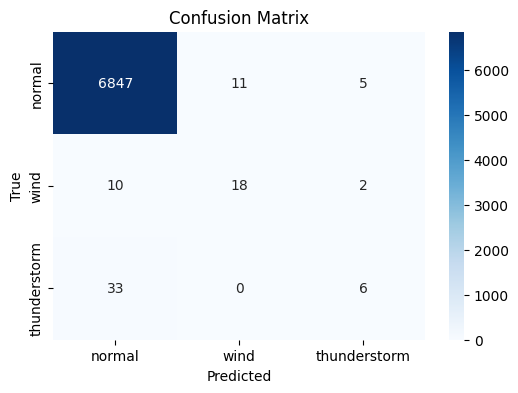

In [15]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define LSTM models
class LSTMClass(nn.Module):
    def __init__(self, input_size=6, hidden=50, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

class LSTMReg(nn.Module):
    def __init__(self, input_size=6, hidden=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Load models
model_c = LSTMClass()
model_c.load_state_dict(torch.load('lstm_class_multi.pth'))
model_c.eval()

model_r = LSTMReg()
model_r.load_state_dict(torch.load('lstm_reg_multi.pth'))
model_r.eval()

# Load test data
X_test = np.load('X_test.npy')
y_class_test = np.load('y_class_test.npy')
y_reg_test = np.load('y_reg_test.npy')
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_class_test_t = torch.tensor(y_class_test, dtype=torch.long)
y_reg_test_t = torch.tensor(y_reg_test, dtype=torch.float32)

# Predict
with torch.no_grad():
    probs = torch.softmax(model_c(X_test_t), dim=1).numpy()
    class_preds = np.argmax(probs, axis=1)
    reg_preds = model_r(X_test_t).numpy().flatten()

# Metrics
class_accuracy = accuracy_score(y_class_test, class_preds)
reg_mse = mean_squared_error(y_reg_test, reg_preds)

print(f"Classification Accuracy: {class_accuracy:.4f}")
print(f"Wind Speed MSE: {reg_mse:.4f}")

# Sample predictions
event_map = {0: 'normal', 1: 'wind', 2: 'thunderstorm'}
sample_preds = pd.DataFrame({
    'True Event': [event_map[y] for y in y_class_test[:5]],
    'Pred Event': [event_map[y] for y in class_preds[:5]],
    'Probabilities': [probs[i].round(3).tolist() for i in range(5)],
    'True Wind Speed': y_reg_test[:5].round(2),
    'Pred Wind Speed': reg_preds[:5].round(2)
})
print("\nSample Predictions:")
print(sample_preds)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_class_test, class_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=event_map.values(), yticklabels=event_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
import pickle
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data to fit scaler (use one city for simplicity, e.g., Ahmedabad)
df = pd.read_csv('multi_city_labeled_fixed.csv')
features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'precipitation']
scaler = StandardScaler().fit(df[df['city'] == 'Ahmedabad'][features])
pickle.dump(scaler, open('scaler.pkl', 'wb'))
print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl
